<div class="alert alert-block alert-warning">

# ⚠️ Instructions ⚠️
- Please read these instructions carefully.
- Make sure your code runs end-to-end after restarting the kernel.
    - Code that does not run **will not be considered in your submission**.
</div>

# Mock Quiz: Classification [28 pts]
## Predicting Injuries in Traffic Crashes
You will apply your Auto-ML to the [Chicago Traffic Crashes Dataset](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d) to predict the extent of injury given the parameters of a vehicular crash.

<div class="alert alert-info">

**Instructions**
    
1. **Read the traffic crash data** from `traffic_crashes_people.csv`.
2. **Examine and clean the dataset**.
3. **Run your AutoML** on the preprocessed dataset.
4. **Discuss** the results and recommendations.

*Note: Attach any additional **module** or **package** that you will use alongside this exercise*
</div>

In [111]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from math import ceil
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.model_selection import KFold



<div class="alert alert-info">
    
### Task 1 - Data Preprocessing [6 pts]
 1. Remove the three columns containing information obtained after the accident.
 2. One-hot encode all categorical columns.
 3. Check for other features that need cleaning in the dataset. Perform any filtering, dropping, transformation, imputation, etc. that you see fit. For example, you can bucket together all infrequent categorical levels into one using the `min_frequency` parameter of `sklearn.preprocessing.OneHotEncoder`.
</div>

In [112]:
data_raw=pd.read_csv("traffic_crashes_people.csv")
data_raw = data_raw.drop(['physical_condition', 'airbag_deployed', 'ejection'], axis=1)
print(len(data_raw))


202077


Data Processing Method 1: Filling na with Unknowns and Imputation

In [113]:

# Cleaning Method 1 (Replace all Missing with UNKNOWN) =========================
data = data_raw.copy()
data['driver_vision'] = data['driver_vision'].fillna('UNKNOWN')
data['safety_equipment'] = data['safety_equipment'].fillna('UNKNOWN')
data = data.dropna()
print(len(data_raw),len(data))
data.head()

202077 96168


,person_type,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,driver_vision,injury_classification
5,DRIVER,CHICAGO,IL,60644,M,32.0,IL,D,SAFETY BELT USED,NOT OBSCURED,NONINCAPACITATING INJURY
6,DRIVER,CHICAGO,IL,60608,M,37.0,IL,D,SAFETY BELT USED,NOT OBSCURED,NONINCAPACITATING INJURY
10,DRIVER,CHICAGO,IL,60620,M,19.0,IL,D,USAGE UNKNOWN,UNKNOWN,NO INDICATION OF INJURY
12,DRIVER,DALLAS,TX,75237,F,46.0,TX,B,USAGE UNKNOWN,UNKNOWN,NO INDICATION OF INJURY
13,DRIVER,CHICAGO,IL,60612,M,47.0,IL,C,USAGE UNKNOWN,NOT OBSCURED,NO INDICATION OF INJURY


Data Processing Method 2: Dropping all Missing Values

In [114]:
# Cleanning Method 2 ================================
data2 = data_raw.copy()
data2 = data2.dropna()
print(len(data_raw), len(data2))
data2.head()

202077 96168


,person_type,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,driver_vision,injury_classification
5,DRIVER,CHICAGO,IL,60644,M,32.0,IL,D,SAFETY BELT USED,NOT OBSCURED,NONINCAPACITATING INJURY
6,DRIVER,CHICAGO,IL,60608,M,37.0,IL,D,SAFETY BELT USED,NOT OBSCURED,NONINCAPACITATING INJURY
10,DRIVER,CHICAGO,IL,60620,M,19.0,IL,D,USAGE UNKNOWN,UNKNOWN,NO INDICATION OF INJURY
12,DRIVER,DALLAS,TX,75237,F,46.0,TX,B,USAGE UNKNOWN,UNKNOWN,NO INDICATION OF INJURY
13,DRIVER,CHICAGO,IL,60612,M,47.0,IL,C,USAGE UNKNOWN,NOT OBSCURED,NO INDICATION OF INJURY


In [115]:
target_col = 'injury_classification'  # <-- your target variable
X = data2.drop(columns=[target_col])
y = data2[target_col]

cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(exclude=['object', 'category']).columns

ohe = OneHotEncoder(
    handle_unknown='infrequent_if_exist',
    min_frequency=0.1,      # 20% threshold for infrequent categories
    sparse_output=False
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

X_encoded = preprocessor.fit_transform(X)
data3 = pd.DataFrame(
    X_encoded,
    columns=preprocessor.get_feature_names_out()
)

data3 = pd.concat([data3,y.reset_index(drop=True)],axis=1)

data3.head()

,cat__person_type_DRIVER,cat__person_type_infrequent_sklearn,cat__city_CHICAGO,cat__city_infrequent_sklearn,cat__state_IL,cat__state_infrequent_sklearn,cat__zipcode_infrequent_sklearn,cat__sex_F,cat__sex_M,cat__sex_infrequent_sklearn,...,cat__drivers_license_class_D,cat__drivers_license_class_infrequent_sklearn,cat__safety_equipment_SAFETY BELT USED,cat__safety_equipment_USAGE UNKNOWN,cat__safety_equipment_infrequent_sklearn,cat__driver_vision_NOT OBSCURED,cat__driver_vision_UNKNOWN,cat__driver_vision_infrequent_sklearn,num__age,injury_classification
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,32.0,NONINCAPACITATING INJURY
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,37.0,NONINCAPACITATING INJURY
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,19.0,NO INDICATION OF INJURY
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,46.0,NO INDICATION OF INJURY
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,47.0,NO INDICATION OF INJURY


<div class="alert alert-info">

### Task 2 - Data Segregation [2 pt]
 1. Use the last 1000 rows as the final test dataset; the remaining as train/validation dataset.
 2. Use a smaller sample **(of at least 8k rows)** as the train/val set in the interest of time.
 3. Set `random_state=1337` to make your sampling procedure reproducible.
</div>

In [121]:

# Separate features and target
X = data3.drop(columns=["injury_classification"])
y = data3[target_col]

# Final test: last 1000 rows (keep deterministic)
X_final_test = X.tail(1000)
y_final_test = y.tail(1000)

# Remaining data
X_rest = X.iloc[:-1000]
y_rest = y.iloc[:-1000]

# Randomly sample 8,000 rows for validation
val_indices = X_rest.sample(n=8000, random_state=1337).index

X_subsample = X_rest.loc[val_indices]
y_subsample = y_rest.loc[val_indices]

# Everything else is training data
X_train = X_rest.drop(index=val_indices)
y_train = y_rest.drop(index=val_indices)

# Reset indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_subsample = X_subsample.reset_index(drop=True)
y_subsample = y_subsample.reset_index(drop=True)
X_final_test = X_final_test.reset_index(drop=True)
y_final_test = y_final_test.reset_index(drop=True)

print(f"Train set: {len(X_train)} rows")
print(f"Validation set: {len(X_subsample)} rows")
print(f"Final test set: {len(X_final_test)} rows")

Train set: 87168 rows
Validation set: 8000 rows
Final test set: 1000 rows


<div class="alert alert-info">

### Task 3 - Model Experimentation [8 pts]
 1. Use at least two (2) tree-based models and one (1) non-tree based model.
 2. Use `3` trials for monte-carlo CV or `k >= 3` for k-fold CV.
 3. Set a validation size of `20%`.
 4. Grid search over the following hyperparameters:
        - max depth of `2` to `5`
        - number of estimators of at least `50`
        - C or alpha [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
</div>

Model Functions

In [122]:
np.arange(1, 12,2)

array([ 1,  3,  5,  7,  9, 11])

In [ ]:
# Number_trials = 3
Number_trials = 3     # number of repeated k-fold runs
n_splits = 5        # number of folds for KFold

def train_knn(X, y):
    score_train = []
    score_test = []

    for seed in range(Number_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # avoid asking for more neighbors than training samples
        # max_k = min(70, len(X_train))
        neighbors_settings = np.arange(1, 12,2)

        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_train, y_train)
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_val, y_val))

        score_train.append(acc_train)
        score_test.append(acc_test)

    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(score), f'N_Neighbor = {np.argmax(score)+1}', 'NA', run_time]


def train_logistic(X, y, reg):
    C = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    score_train = []
    score_test = []
    weighted_coefs = []

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        for alpha_run in C:
            if reg == 'l1':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear', max_iter=1000).fit(X_train, y_train)
            elif reg == 'l2':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='lbfgs', max_iter=1000).fit(X_train, y_train)

            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_val, y_val))
            weighted_coefs.append(lr.coef_)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)

    flat_coefs = np.abs(mean_coefs).ravel()[:len(X.columns)]
    top_predictor = X.columns[np.argmax(flat_coefs)]

    abs_mean_coefs = np.abs(mean_coefs[0, :])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3, 3 + coefs_count))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.show()

    run_time = (time.time() - start_time)
    return [f'Logistic ({reg})', np.amax(score),
            f'C = {C[np.argmax(score)]}', top_predictor, run_time]


def train_svm(X, y, reg):
    C = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    score_train = []
    score_test = []
    weighted_coefs = []

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False, max_iter=1000).fit(X_train, y_train)
            elif reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg, max_iter=1000).fit(X_train, y_train)

            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_val, y_val))
            weighted_coefs.append(svc.coef_)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)

    flat_coefs = np.abs(mean_coefs).ravel()[:len(X.columns)]
    top_predictor = X.columns[np.argmax(flat_coefs)]

    abs_mean_coefs = np.abs(mean_coefs[0, :])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3, 3 + coefs_count))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.show()

    run_time = (time.time() - start_time)
    return [f'Linear SVM ({reg})', np.amax(score),
            f'C = {C[np.argmax(score)]}', top_predictor, run_time]

def train_rf(X, y):
    score_train = []
    score_test = []
    best_params = []
    best_estimators = []

    for seed in range(10):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        param_grid = {
        'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
        'max_depth': list(range(1, 6)),      # Maximum depth of individual trees
        'max_features': ['sqrt'] # Number of features to consider when looking for the best split
        }

        rf = RandomForestClassifier(random_state=0)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        score_train.append(grid_search.score(X_train, y_train))
        score_test.append(grid_search.score(X_val, y_val))
        best_params.append(grid_search.best_params_)
        best_estimators.append(grid_search.best_estimator_)

    best_estimator = best_estimators[np.argmax(score_test)]
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['Random Forest', np.amax(score), str(best_params[np.argmax(score_test)]), \
            X.columns[np.argmax(best_estimator.feature_importances_)], run_time]

def train_gbm(X, y):
    score_train = []
    score_test = []
    best_params = []
    best_estimators = []

    for seed in range(10):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        param_grid = {
        'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]    # Learning Rate
        }

        gbm = GradientBoostingClassifier(random_state=0)
        grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        score_train.append(grid_search.score(X_train, y_train))
        score_test.append(grid_search.score(X_val, y_val))
        best_params.append(grid_search.best_params_)
        best_estimators.append(grid_search.best_estimator_)

    best_estimator = best_estimators[np.argmax(score_test)]
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['Gradient Boosting Method', np.amax(score), str(best_params[np.argmax(score_test)]), \
            X.columns[np.argmax(best_estimator.feature_importances_)], run_time]


Model run

In [123]:
# feature_names = ['mass', 'width', 'height', 'color_score']
# X_raw = data3.drop(columns=['injury_classification'])
# # XX_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# y = data3['injury_classification']

X_raw = X_subsample
y = y_subsample

import time

start_time = time.time()
a = train_knn(X_raw, y)
print(a)
print("%s seconds" % a[4])


['kNN', np.float64(0.925625), 'N_Neighbor = 3', 'NA', 3.670212745666504]
3.670212745666504 seconds


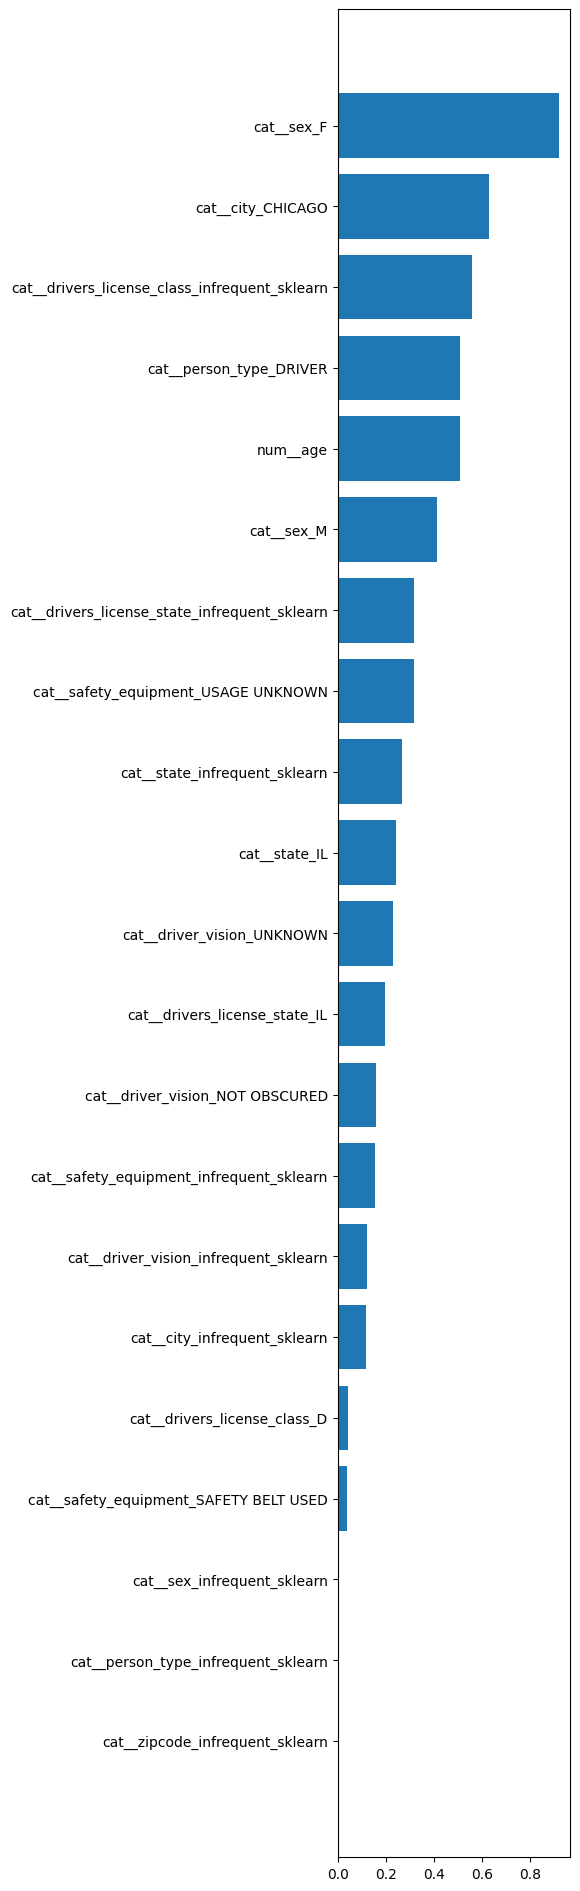

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is depreca

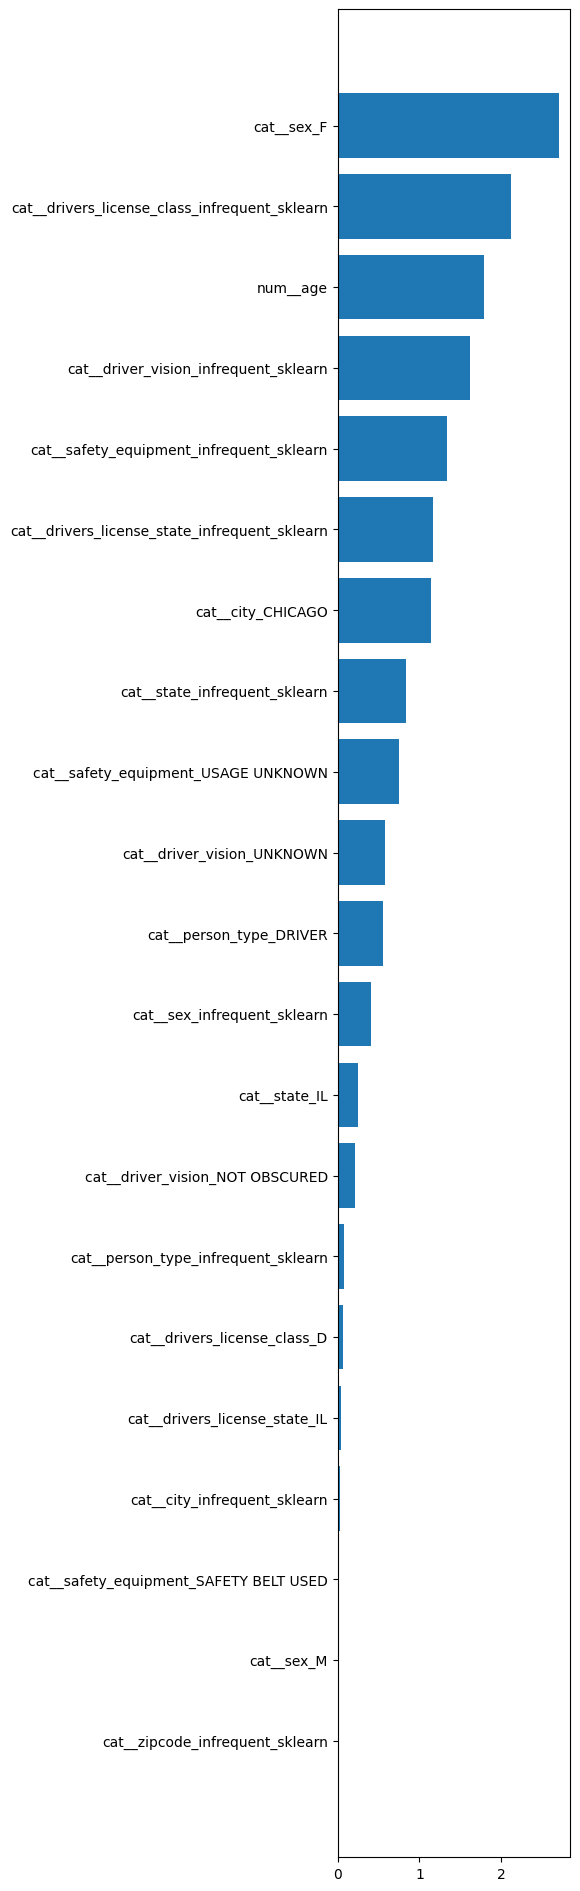

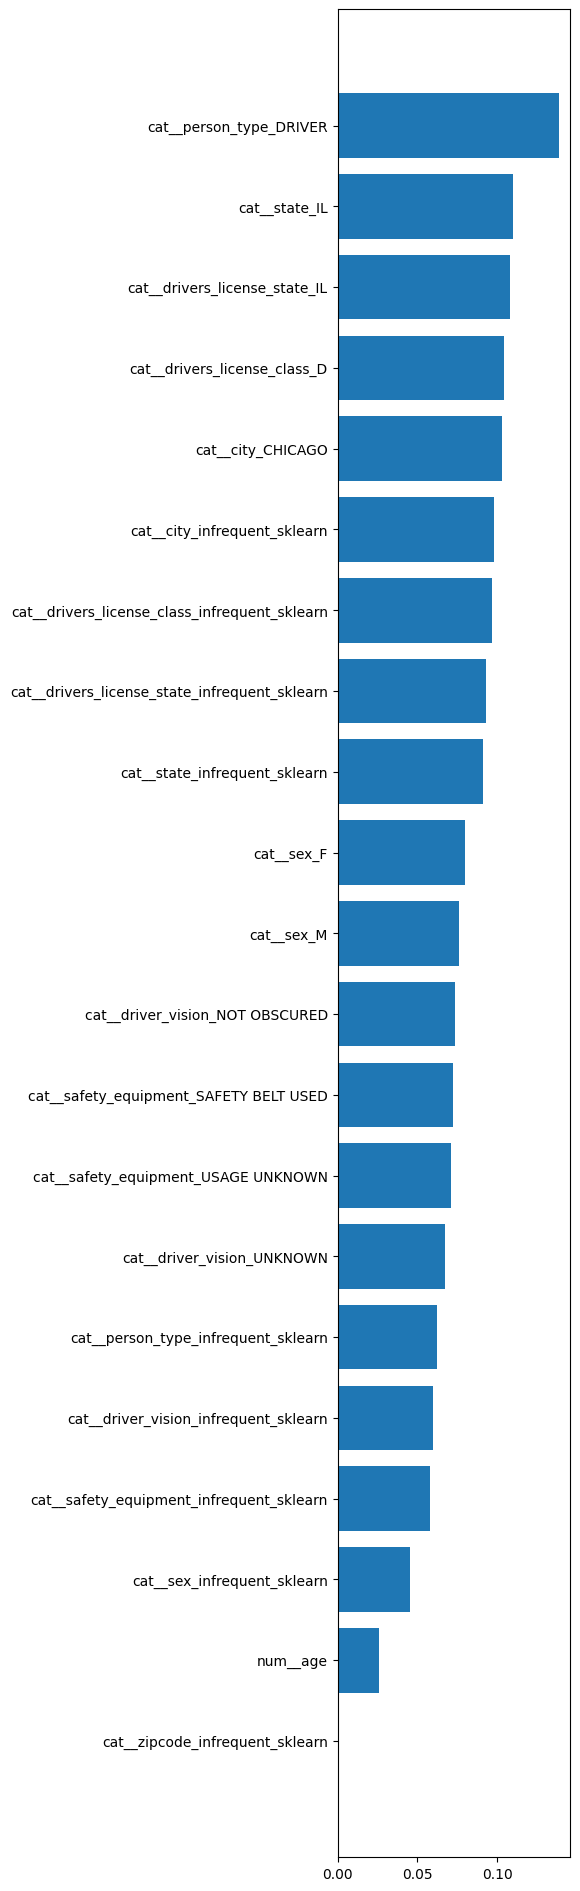

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.w

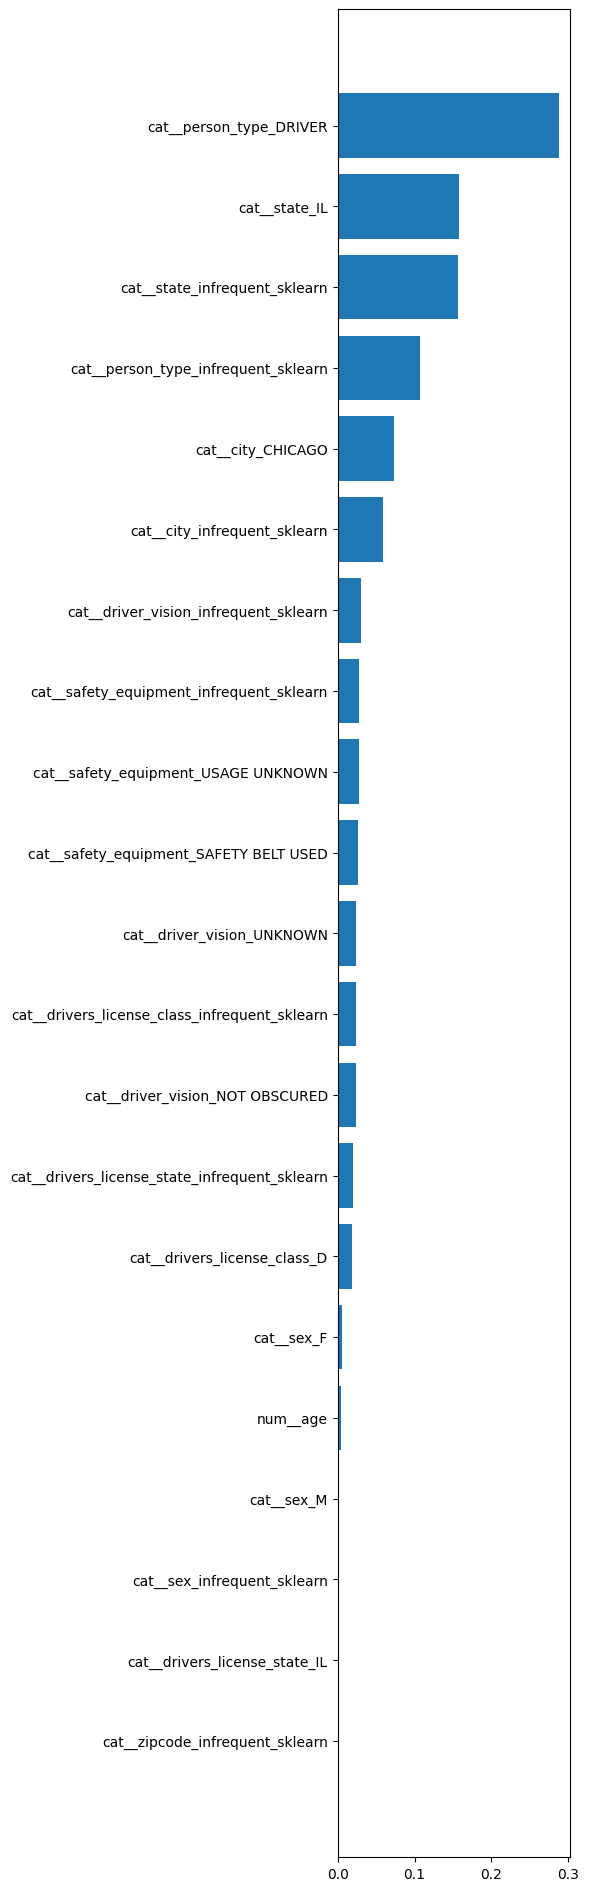

ValueError: Found input variables with inconsistent numbers of samples: [96168, 8000]

In [ ]:

start_time = time.time()
b = train_logistic(X_raw, y, reg='l2')
start_time = time.time()
c = train_logistic(X_raw, y, reg='l1')
start_time = time.time()
d = train_svm(X_raw, y, reg='l2')
start_time = time.time()
e = train_svm(X_raw, y, reg='l1')
start_time = time.time()
f = train_rf(X_raw,y)
start_time = time.time()
g = train_gbm(X_raw,y)


print(b)
print("%s seconds" % b[4])
print(c)
print("%s seconds" % c[4])
print(d)
print("%s seconds" % d[4])
print(e)
print("%s seconds" % e[4])
print(f)
print("%s seconds" % f[4])
print(g)
print("%s seconds" % g[4])


<div class="alert alert-info">
    
### Task 4 - Model Results and Discussion [4 pts]
 1. Display a summary table with the following information: train accuracy, val/test accuracy, best parameter, train time, and top predictor.
 2. Justify what model you will use? At what hyperparameter? Why?
 3. Generate the feature importance plot of your chosen best model.
 4. Give insights on the features deemed important by the best model.    
</div>

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c
df2.loc[3] = d
df2.loc[4] = e
df2.loc[5] = f
df2.loc[6] = g

df2

<div class="alert alert-block alert-info">
    
### Task 5 - Business Value Articulation [6 pts]

Understanding the analysis results using any of the machine learning models you have implemented above, write guidelines, criteria, or recommendations for triage to be used by emergency personnel for these types of accidents (2-4 sentences or bullet points). [3 pts]
</div>

Your answer here

</div><div class="alert alert-info">

### Task 6 [2 pts]
 1. Predict on the final test set (last 1000 rows of original data) using your best-performing model.
 2. Show and comment on the resulting confusion matrix.
    
</div>